In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [3]:
import pandas as pd
from src.config import TRANSFORMED_DATA_DIR

df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")

In [4]:
from datetime import datetime

from src.data_utils import split_time_series_data

X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=datetime(2023, 9, 1, 0, 0, 0),
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55900, 674)
(55900,)
(31720, 674)
(31720,)


In [5]:
past_ride_columns = [c for c in X_train.columns if c.startswith("rides_")]
X_train_only_numeric = X_train[past_ride_columns]
X_test_only_numeric = X_test[past_ride_columns]

In [1]:
import lightgbm as lgb
model = lgb.LGBMRegressor()
model.fit(X_train_only_numeric, y_train)

NameError: name 'X_train_only_numeric' is not defined

In [7]:
from sklearn.metrics import mean_absolute_error
predictions = model.predict(X_test_only_numeric)

In [8]:
test_mae = mean_absolute_error(y_test, predictions)
print(f"{test_mae:.4f}")

3.3054


In [9]:
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow
from dotenv import load_dotenv
import os
load_dotenv() 

mlflow = set_mlflow_tracking()
log_model_to_mlflow(model, X_test_only_numeric, "LGBMRegressor", "mean_absolute_error", score=test_mae)

INFO:src.experiment_utils:MLflow tracking URI and credentials set.
INFO:src.experiment_utils:Experiment set to: LGBMRegressor
INFO:src.experiment_utils:Logged mean_absolute_error: 3.3054128762542527
C:\Users\mkhaw\anaconda3\envs\sp25_taxi\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
INFO:src.experiment_utils:Model

🏃 View run rambunctious-hen-965 at: https://dagshub.com/mkzia/sp25_taxi.mlflow/#/experiments/4/runs/2c06232cde6545f1a221e0356a2c0117
🧪 View experiment at: https://dagshub.com/mkzia/sp25_taxi.mlflow/#/experiments/4


ERROR:src.experiment_utils:An error occurred while logging to MLflow: 


MemoryError: 

2025/03/02 19:09:02 INFO mlflow.tracking.fluent: Experiment with name 'NYC_Taxi_LightGBM_Tuning' does not exist. Creating a new experiment.
2025/03/02 19:09:02 WARNING mlflow.utils.autologging_utils: MLflow lightgbm autologging is known to be compatible with 3.3.5 <= lightgbm <= 4.5.0, but the installed version is 4.6.0. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a compatible version, or try upgrading MLflow.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159651
[LightGBM] [Info] Number of data points in the train set: 55900, number of used features: 672
[LightGBM] [Info] Start training from score 11.110286
Learning Rate: 0.01 | MAE: 7.971859486998356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159651
[LightGBM] [Info] Number of data points in the train set: 55900, number of used features: 672
[LightGBM] [Info] Start training from score 11.110286
Learning Rate: 0.05 | MAE: 3.386197397898954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.03

2025/03/02 19:16:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 1000x600 with 0 Axes>

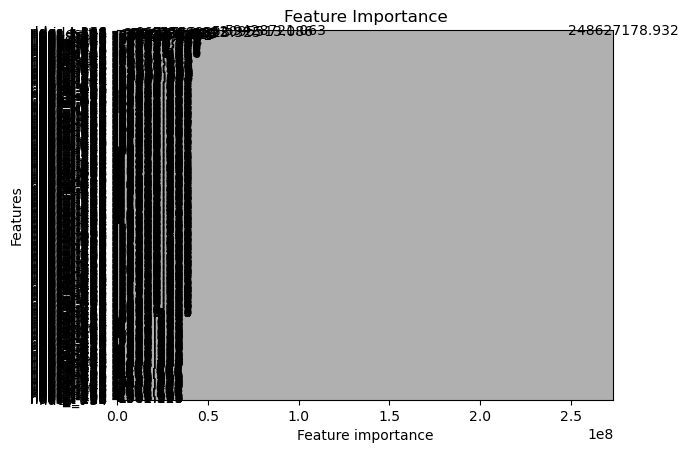

In [1]:
# Import necessary libraries
import mlflow
import mlflow.lightgbm
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load dataset
from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data

df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")

# Train-test split
X_train, y_train, X_test, y_test = split_time_series_data(
    df, cutoff_date=datetime(2023, 9, 1, 0, 0, 0), target_column="target"
)

# Select numeric features
past_ride_columns = [c for c in X_train.columns if c.startswith("rides_")]
X_train_only_numeric = X_train[past_ride_columns].astype("float64")
X_test_only_numeric = X_test[past_ride_columns].astype("float64")

# Set up MLflow
mlflow.set_experiment("NYC_Taxi_LightGBM_Tuning")
mlflow.lightgbm.autolog()

# Step 1: Tune learning_rate
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
best_mae = float("inf")
best_lr = None

for lr in learning_rates:
    with mlflow.start_run(nested=True):  # Nested run for MLflow logging
        model = lgb.LGBMRegressor(learning_rate=lr, num_leaves=31, n_estimators=100)
        model.fit(X_train_only_numeric, y_train)

        predictions = model.predict(X_test_only_numeric)
        test_mae = mean_absolute_error(y_test, predictions)

        mlflow.log_param("learning_rate", lr)
        mlflow.log_metric("test_MAE", test_mae)

        print(f"Learning Rate: {lr} | MAE: {test_mae}")

        if test_mae < best_mae:
            best_mae = test_mae
            best_lr = lr

print(f"Best Learning Rate: {best_lr}")

# Step 2: Tune num_leaves & n_estimators with best learning_rate
num_leaves_options = [31, 50, 100]
n_estimators_options = [50, 100, 200]
best_model = None

for num_leaves in num_leaves_options:
    for n_estimators in n_estimators_options:
        with mlflow.start_run(nested=True):  # Nested run for MLflow logging
            model = lgb.LGBMRegressor(learning_rate=best_lr, num_leaves=num_leaves, n_estimators=n_estimators)
            model.fit(X_train_only_numeric, y_train)

            predictions = model.predict(X_test_only_numeric)
            test_mae = mean_absolute_error(y_test, predictions)

            mlflow.log_params({"num_leaves": num_leaves, "n_estimators": n_estimators})
            mlflow.log_metric("test_MAE", test_mae)

            print(f"Num Leaves: {num_leaves} | N Estimators: {n_estimators} | MAE: {test_mae}")

            if test_mae < best_mae:
                best_mae = test_mae
                best_model = model

print("Final best MAE:", best_mae)

# Log best model to MLflow
mlflow.lightgbm.log_model(best_model, artifact_path="best_lightgbm_model")

# Feature Importance Plot
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_model, importance_type="gain")
plt.title("Feature Importance")
plt.show()
